# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

In [1]:
# загрузим те библиотеки, которые понадобятся в исследовании
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

Посмотрим какие данные предоставлены

Описание данных:

Набор данных находится в файле /datasets/insurance.csv

Признаки: **пол**, **возраст** и **зарплата застрахованного**, **количество членов его семьи**

Целевой признак: **количество страховых выплат клиенту за последние 5 лет**

In [2]:
data = pd.read_csv('/datasets/insurance.csv')

In [3]:
display(data)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


Посмотрим основную информацию о предоставленном датафрейме:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
data.isna().sum()

Пол                  0
Возраст              0
Зарплата             0
Члены семьи          0
Страховые выплаты    0
dtype: int64

In [6]:
data.duplicated().sum()

153

Можно сделать следующие выводы: по-хорошему лучше удалить строки-дубликаты, а так же перевести колонки возраста и зарплаты в тип данных int, так как судя по всему десятичная часть там всегда просто равна 0 и не имеет смысла держать эти данные в формате float. Так же столбцы привычнее видеть названными на английском, чтобы данный код был общедоступным и читабельным для всех

In [7]:
data = data.drop_duplicates().reset_index(drop=True)

In [8]:
# убедимся, что удаление прошло успешно
data.shape[0]

4847

In [9]:
data.rename(columns={'Пол':'gender', 'Возраст':'age', 'Зарплата':'income',
                     'Члены семьи':'family_size', 'Страховые выплаты':'insurance_payments'}, inplace=True)

In [10]:
# убедимся, что замена прошла верно
data.columns

Index(['gender', 'age', 'income', 'family_size', 'insurance_payments'], dtype='object')

In [11]:
# посмотрим, действительно ли десятичная часть равна 0 в колонках возраста и зарплаты
def decimal_part(data_column):
    values = []
    for i in range(data.shape[0]):
        if str(data_column.loc[i])[-1] not in values:
            values.append(str(data_column.loc[i])[-1])
    return values

In [12]:
decimal_part(data['age'])

['0']

In [13]:
decimal_part(data['income'])

['0', '4', '1', '9']

Всё-таки проверка показала, что в столбце зарплат есть ячейки с ненулевым значением после запятой - этот столбец оставим в формате float для того, чтобы не потерять уникальные данные о клиентах. А вот столбец **age** можно смело переводить в int

In [14]:
data['age'] = data['age'].astype('int')

Посмотрим снова на датафрейм после всех преобразований:

In [15]:
display(data)

,gender,age,income,family_size,insurance_payments
0,1,41,49600.0,1,0
1,0,46,38000.0,1,1
2,0,29,21000.0,0,0
3,0,21,41700.0,2,0
4,1,28,26100.0,0,0
...,...,...,...,...,...
4842,0,28,35700.0,2,0
4843,0,34,52400.0,1,0
4844,0,20,33900.0,2,0
4845,1,22,32700.0,3,0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              4847 non-null   int64  
 1   age                 4847 non-null   int64  
 2   income              4847 non-null   float64
 3   family_size         4847 non-null   int64  
 4   insurance_payments  4847 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 189.5 KB


Проанализируем отдельно данные по колонкам:

In [17]:
data['gender'].value_counts()

0    2431
1    2416
Name: gender, dtype: int64

<AxesSubplot:>

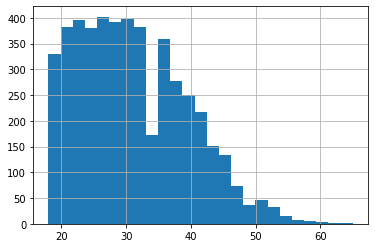

In [18]:
data['age'].hist(bins=25)

<AxesSubplot:>

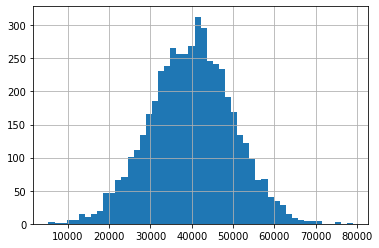

In [19]:
data['income'].hist(bins=50)

In [20]:
data['family_size'].value_counts()

1    1748
0    1461
2    1038
3     437
4     124
5      32
6       7
Name: family_size, dtype: int64

In [21]:
data['insurance_payments'].value_counts()

0    4284
1     423
2     114
3      18
4       7
5       1
Name: insurance_payments, dtype: int64

Можно сказать, что у данных вполне адекватные значения и в них отсутствуют какие-либо аномальные величины

## Умножение матриц

По условию проекта в данном пункте нужно ответить на следующие вопросы:

Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)

**a**. Изменится. Приведите примеры матриц.

**b**. Не изменится. Укажите, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.

Для начала проверим, что линейная регрессия действительно работает по формулам из теоретической части курса, а уже потом будем анализировать что происходит, если эту формулу менять

In [22]:
# создадим собственный класс линейной регрессии
class Selfmade_LinearRegression:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]
        
    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0
    
    def intercept_(self):
        return self.w0
    
    def coef_(self):
        return self.w

Если это класс сделанной вручную модели покажет нам, что коэф-ты w0 и w такие же, как и у готового класса модели LinearRegression, то это будет обозначать, что данной моделью можно пользоваться для дальнейших экспериментов и ответов на вопросы проекта

Так как в дальнейшем в любом случае придется это сделать, то разобьём уже на данном этапе данные на валидационную и тренировочную выборки

In [23]:
features = data.drop('insurance_payments', axis=1)
target = data['insurance_payments']

In [24]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Проверим полученные данные для обучения и проверки модели:

In [25]:
display(features_train)

,gender,age,income,family_size
4460,0,28,54500.0,2
3773,1,38,50700.0,1
4561,0,24,28000.0,1
1385,0,47,38800.0,0
724,0,40,32500.0,1
...,...,...,...,...
3497,1,23,28200.0,1
3492,0,30,33700.0,1
2177,1,20,28900.0,1
3557,1,33,38800.0,1


In [26]:
display(features_valid)

,gender,age,income,family_size
1321,1,23,47200.0,0
3767,1,32,65900.0,0
166,1,33,33900.0,2
2935,0,39,19300.0,2
423,0,46,27500.0,2
...,...,...,...,...
1571,1,35,23000.0,1
32,1,30,51000.0,2
359,1,26,33500.0,3
2799,0,25,33100.0,0


In [27]:
display(target_train)

4460    0
3773    0
4561    0
1385    1
724     0
       ..
3497    0
3492    0
2177    0
3557    0
4578    0
Name: insurance_payments, Length: 3635, dtype: int64

In [28]:
display(target_valid)

1321    0
3767    0
166     0
2935    0
423     1
       ..
1571    0
32      0
359     0
2799    0
643     2
Name: insurance_payments, Length: 1212, dtype: int64

In [29]:
selfmade_model = Selfmade_LinearRegression()
real_model = LinearRegression()

In [30]:
selfmade_model.fit(features_train, target_train)
real_model.fit(features_train, target_train);

In [31]:
print(f'Коеффициенты w0 : {selfmade_model.intercept_()}' , '\n', f'и w : {selfmade_model.coef_()} искусственной модели')

Коеффициенты w0 : -0.9767095974773905 
 и w : [ 1.45766002e-02  3.64782926e-02  1.79477716e-07 -1.23345013e-02] искусственной модели


In [32]:
print(f'Коеффициенты w0 : {real_model.intercept_}' , '\n', f'и w : {real_model.coef_} настоящей модели')

Коеффициенты w0 : -0.9767095974777154 
 и w : [ 1.45766002e-02  3.64782926e-02  1.79477716e-07 -1.23345013e-02] настоящей модели


Как видно - есть полное совпадение. Можно утверждать что на созданном вручную классе можно делать все проверки гипотез, как будто на настоящей модели

Теперь собственно займёмся проверкой выше записанного утверждения о том, что при умножении признаков на некую обратимую матрицу будет изменяться или не изменяться качество линейной регрессии. Иными словами, нужно чтобы не поменялись прогнозы, которые делает модель. Как я понимаю, на данном этапе нужно именно формульное доказательство

$$
a = XP((XP)^{T}(XP))^{-1}(XP)^{T}y = XP(P^{T}X^{T}XP)^{-1}(XP)^{T}y = XPP^{-1}(X^{T}X)^{-1}(P^{T})^{-1}P^{T}X^{T}y = X(X^{T}X)^{-1}X^{T}y = Xw
$$

Как видно, было доказано, что если мы будем умножать на обратимую матрицу исходные признаки, то на предсказание это не повлият - та обратимая матрица сократится в ходе математических преобразований

## Алгоритм преобразования

Собственно говоря, теперь мы можем использовать полученное доказательство для зашифровки данных. 

Для начала обучим модель без зашифрованных данных и проверим у неё метрику R2 , а потом будем шифровать исходные данные при помощи их умножения на обратимую матрицу, и докажем, что точность предсказаний не меняется.

Обратная матрица, на которую мы будем умножать, должна соответствовать 2-м признакам:

1. иметь ненулевой определитель - то есть быть обратимой
2. иметь число строк = числу столбцов матрицы признаков

## Проверка алгоритма

Для начала обучим и проверим матрицу на тестовой выборке без применения шифрования. Обучение уже было сделано ранее, так что можем сразу приступить к предсказаниями 

In [33]:
predictions_real_model = real_model.predict(features_valid)
r_metric_real_model = r2_score(target_valid, predictions_real_model)
# ради интереса убедимся, что самостоятельно созданный класс данной модели показывает ту же точность предсказаний:
predictions_selfmade_model = selfmade_model.predict(features_valid)
r_metric_selfmade_model = r2_score(target_valid, predictions_selfmade_model)

In [34]:
print(f'Метрика R2 для реальной модели регрессии: {r_metric_real_model:.3f}')
print(f'Метрика R2 для самодельной модели регрессии: {r_metric_selfmade_model:.3f}')

Метрика R2 для реальной модели регрессии: 0.423
Метрика R2 для самодельной модели регрессии: 0.423


Как и ожидалось, ранее сделанная самостоятельно модель оказалась полностью рабочей. Теперь взяв её за основу немного переделаём логику класса, чтобы работать с зашифрованными данными

Для начала проверим, как работает генерация случайной матицы c размером n x n , где n - это число признаков

In [35]:
while True:
    n = features.shape[1]                                                 # размер = числу признаков
    random_matrix = np.random.uniform(low=-100, high=100, size=(n, n))    
    if np.linalg.det(random_matrix) != 0:                                 # проверка, что определитель не равен 0
        print(random_matrix)
        break

[[-94.47793381 -41.86431323 -44.57937793 -80.1744519 ]
 [ 58.78231026 -18.00315366  -9.23102209  36.76865003]
 [-84.51526729  -6.1272176  -90.96393789  76.87045068]
 [ 55.30991937  31.54922785  38.7433499   -6.00642093]]


Теперь такой же генератор нужно поместить внутрь нового класса, который будет шифровать данные:

In [36]:
class Crypted_LinearRegression:
    def fit(self, train_features, train_target):
        while True:
            n = train_features.shape[1]
            self.random_matrix = np.random.uniform(low=-100, high=100, size=(n, n))    
            if np.linalg.det(random_matrix) != 0:
                break
        self.crypted_features = train_features @ self.random_matrix
        X = np.concatenate((np.ones((self.crypted_features.shape[0], 1)), self.crypted_features), axis=1)       
        y = train_target
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]
        
    def predict(self, test_features):
        crypted_features = test_features @ self.random_matrix
        return crypted_features.dot(self.w) + self.w0
    
    def intercept_(self):
        return self.w0
    
    def coef_(self):
        return self.w
    
    def crypted_data(self):
        return self.crypted_features

In [37]:
crypted_model = Crypted_LinearRegression()
crypted_model.fit(features_train, target_train)
crypted_model_predictions = crypted_model.predict(features_valid)
r_metric_encrypted_model = r2_score(target_valid, crypted_model_predictions)

In [38]:
print(f'Точность предсказаний по метрике R2 для модели, работавшей с зашифрованными данными: {r_metric_encrypted_model:.3f}')

Точность предсказаний по метрике R2 для модели, работавшей с зашифрованными данными: 0.423


Как видно, это успех - если умножать признаки на обратимую матрицу, то предсказания действительно останутся так же точны, как и сделанные ранее на незашифрованных данных. Посмотрим ради интереса как выглядели зашифрованные данные:

In [39]:
display(crypted_model.crypted_data())

,0,1,2,3
4460,3.957149e+06,-3.687043e+06,-518012.104830,4.117139e+06
3773,3.680439e+06,-3.430176e+06,-482455.775096,3.831326e+06
4561,2.032383e+06,-1.894361e+06,-266624.549995,2.116155e+06
1385,2.815318e+06,-2.625276e+06,-370083.589841,2.933751e+06
724,2.358192e+06,-2.198947e+06,-310085.951906,2.457426e+06
...,...,...,...,...
3497,2.047020e+06,-1.907913e+06,-268472.013992,2.131234e+06
3492,2.446034e+06,-2.280024e+06,-320946.248653,2.547057e+06
2177,2.098071e+06,-1.955237e+06,-274952.046643,2.183792e+06
3557,2.816345e+06,-2.625098e+06,-369432.113684,2.932449e+06


Выглядит надежно защищенным.

По итогу: теорема о том, что умножение ("шифрование") признаков на некую обратимую матрицу (правильного размера, чтобы матричное перемножение было возможно) не меняет точности предсказаний доказано как матиматически, так и практически

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные загружены
- [x]  Выполнен шаг 2: получен ответ на вопрос об умножении матриц
    - [x]  Указан правильный вариант ответа
    - [x]  Вариант обоснован
- [x]  Выполнен шаг 3: предложен алгоритм преобразования
    - [x]  Алгоритм описан
    - [x]  Алгоритм обоснован
- [x]  Выполнен шаг 4: алгоритм проверен
    - [x]  Алгоритм реализован
    - [x]  Проведено сравнение качества моделей до и после преобразования